## Creating_GTD.ipynb


Creat the ground truth dataset for European blocking events

This is done by creating a PDF containing the spaghetti plots and five days of geopotential height data for every continuous five day period within JJA.

From manual inspection, I can then determine myself if a blocking event persists across that five day interval

This creates a dataset that can be translated into a blocking specification for the days in Europe when a summer blocking event has occurred.




In [1]:
import netCDF4 as nc
import xarray
import xarray as xr
import numpy as np
import scipy
from collections import OrderedDict 
#from windspharm.iris import VectorWind
from scipy.integrate import simps
import glob
import matplotlib.pyplot as plt
#import PDF_funcs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from itertools import groupby
from operator import itemgetter
#for mapping the polygon on a sphere to a polygon on a flat surface to calculate area
import pyproj
import math
from shapely import geometry
import collections
from shapely.geometry import Point
from matplotlib.path import Path
import pandas as pd
import itertools
from operator import itemgetter
from itertools import groupby
from IPython.display import clear_output
import datetime
import matplotlib.patches as mpatches
from cartopy.util import add_cyclic_point
#import xscale
#from ipywidgets import widgets

In [2]:
import pickle

In [3]:
import cfgrib

In [4]:
import plot_funcs as pf

# 2. Load files for plotting

zg_eur holds the JJA europe data to create the sets of five consecutive maps and geop_twicedaily hold the 12 hr snapshots of gph in NH midlatitudes for the spaghetti plots


In [5]:
#load files to calculate the number of days in the dataset
zg_file=xarray.open_dataset("C:/Users/carlt/Documents/PhD/Data/reanal/era5/ERA5_1979-2019_geopotential_500hPa_daymean.nc")['z']/9.80665

zg_anom=xarray.open_dataset("C:/Users/carlt/Documents/PhD/Data/reanal/era5/zg/500zg_JJA_1x1_1979-2019_daymean_LTDManom_EurAR5.nc")['z']
zg_anom_dtrnd=xarray.open_dataset("C:/Users/carlt/Documents/PhD/Data/reanal/era5/zg/500zg_JJA_1x1_1979-2019_daymean_LTDManom_EurAR5_dtrnd_wrttime.nc")['z']

ipv = xr.open_dataset("C:/Users/carlt/Documents/PhD/Data/reanal/era5/pv/isentropic/pv_350pt_era5_1979-2019_1x1_tot_3hr_daymean.nc")['pv'].sel(latitude=np.arange(30,76), longitude=np.arange(-10,41))*1e6
ipv_LTDM_anom = xr.open_dataset("C:/Users/carlt/Documents/PhD/Data/reanal/era5/pv/isentropic/pv_350pt_era5_1979-2019_1x1_tot_3hr_daymean_ydayavg_LTDManom_invlat.nc")['pv'].sel(latitude=np.arange(30,76), longitude=np.arange(-10,41))*1e6

ipv_sel = ipv.sel(time = np.isin(ipv['time.season'], "JJA"))
ipv_LTDM_anom_sel = ipv_LTDM_anom.sel(time = np.isin(ipv_LTDM_anom['time.season'], "JJA"))
vpv = xr.open_dataset("C:/Users/carlt/Documents/PhD/Data/reanal/era5/pv/isobaric/pv_JJA_1979-2019_150-500_1x1_hires.nc")['pv'].sel(latitude=np.arange(30,76), longitude=np.arange(-10,41))*1e6


zg_eur = zg_file.sel(time = np.isin(zg_file['time.season'], "JJA"))
geop_twicedaily = xarray.open_dataset("C:/Users/carlt/Documents/PhD/Data/reanal/era5/500zg_1x1_1979-2019_12hr_NHML.nc")['zg']

In [6]:
geop_twicedaily

<xarray.DataArray 'zg' (time: 7544, latitude: 56, longitude: 360)>
[152087040 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 25.0 26.0 27.0 28.0 ... 77.0 78.0 79.0 80.0
  * time       (time) datetime64[ns] 1979-06-01 ... 2019-08-31T12:00:00

In [7]:
zg_anom_tot = pf.calc_seas_anom(zg_file)

AttributeError: module 'plot_funcs' has no attribute 'calc_seas_anom'

In [8]:
#detrend file wrt time
def dtrnd_wrt_time(anom_da):
    time_idx_arr = np.arange(anom_da['time'].shape[0])
    m, c, r, p, stderr = stats.linregress(time_idx_arr, pf.fldmean_xr(anom_da))
    anom_da_dtrnd_arr = [anom_da[i] - i*m - c for i in time_idx_arr]
    anom_da_dtrnd = xr.concat(anom_da_dtrnd_arr, dim = "time")
    return anom_da_dtrnd

In [16]:
#zg_anom_tot_dtrnd = dtrnd_wrt_time(zg_anom_tot)
#zg_anom_tot_dtrnd.to_netcdf("C:/Users/carlt/Documents/PhD/Data/reanal/era5/ERA5_1979-2019_geopotential_500hPa_daymean_EUR_daymean_tot_dtrnd.nc")

In [6]:

m, c, r, p, stderr = stats.linregress(np.arange(zg_anom['time'].shape[0]), pf.fldmean_xr(zg_anom))
zg_anom_dtrnd_arr = [zg_anom[i] - i*m - c for i in np.arange(3772)]
zg_anom_dtrnd = xr.concat(zg_anom_dtrnd_arr, dim = "time")
#zg_anom_dtrnd.to_netcdf("C:/Users/carlt/Documents/PhD/Data/reanal/era5/zg/500zg_JJA_1x1_1979-2019_daymean_LTDManom_EurAR5_dtrnd_wrttime.nc")

In [7]:


ipv_anom_350 = pf.calc_seas_anom(ipv_LTDM_anom_sel)
vpv_anom = pf.calc_seas_anom(vpv)

In [8]:
ipv_anom_300 = xr.open_dataset("C:/Users/carlt/Documents/PhD/Data/reanal/era5/pv/isentropic/pv_300pt_era5_1979-2019_1x1_JJA_daymean_anom.nc")['pv'].sel(latitude=np.arange(35,76), longitude=np.arange(-10,41))*1e6


In [9]:
from matplotlib.backends.backend_pdf import PdfPages
from csv import writer

In [10]:
#create a new colourmap

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
class MplColorHelper:
        def __init__(self, cmap_name, start_val, stop_val):
            self.cmap_name = cmap_name
            self.cmap = plt.get_cmap(cmap_name)
            self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
            self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

        def get_rgb(self, val):
            return self.scalarMap.to_rgba(val)


COL = MplColorHelper('seismic', -330, 330)
bounds = np.arange(-330,360,30)
cols=COL.get_rgb(bounds)

green_cols = np.array(list(zip(cols[:,1],cols[:,0],cols[:,2],cols[:,3])))[12:]
purp_cols = np.array(list(zip(cols[:,0],cols[:,1],cols[:,0],cols[:,3])))[12:]

cols_cont_rearr = np.concatenate((np.flip(purp_cols, 0), green_cols), axis = 0)
newcmp = ListedColormap(cols_cont_rearr)


In [11]:

day_idx = 0
num_days = 5
alpha_sp = 0.8
fs_sp_lab = 9
fs_contour_plots = 7
fs_cb_ticks = 7
fs_cb_label = 7

def date_str(date):
    day, month, year_str = int(date.dt.day), int(date.dt.month), int(date.dt.year)
    day_str, month_str = f"{day:02d}", f"{month:02d}"
    date_str = f"{day_str}-{month_str}-{year_str}"
    return date_str

def consecutive_weather_maps(day_idx, num_days):
    """
    Plots a set of consecutive weather maps, including spaghetti plots of the gph field and five plots of the anomaly field
    """
    st_date = zg_anom_dtrnd['time'][day_idx]
    end_date = zg_anom_dtrnd['time'][day_idx+num_days-1]

    st_date_str = date_str(st_date)
    end_date_str = date_str(end_date)

    # Initialize the grid
    grid = plt.GridSpec(3, num_days, wspace=0.1, hspace=0)
    fig = plt.figure()
    axs = []
    # make subplots

    levels_vpv=np.arange(-3, 3.3, 0.3)
    levels_ipv=np.arange(-1.5, 1.65, 0.15)     
    levels_zg=np.arange(-330,360,30)
        
    for i in range(day_idx, day_idx+num_days):
        ax = plt.subplot(grid[1, i-day_idx], projection = ccrs.PlateCarree())
        axs.append(ax)
        #cs_zg = ax.contourf(ipv_anom_350['longitude'], ipv_anom_350['latitude'], vpv_anom[i], levels_vpv, cmap=plt.get_cmap("seismic"), extend="both")
        #cs_zg = ax.contourf(ipv_anom_350['longitude'], ipv_anom_350['latitude'], zg_anom_dtrnd[i], levels_zg, cmap=plt.get_cmap("seismic"), extend="both")
        cs_zg = ax.contourf(zg_anom_dtrnd['longitude'], zg_anom_dtrnd['latitude'], zg_anom_dtrnd[i], levels_zg, cmap=plt.get_cmap("seismic"), extend="both")
        ax.set_title(f"{date_str(zg_anom_dtrnd['time'][i])}", fontsize=fs_contour_plots, pad=-1)
        #ax.set_title(f"{date_str(zg_eur['time'][i])}", fontsize=fs_contour_plots, pad=-1)
        ax.coastlines()        

    for i in range(day_idx, day_idx+num_days):
        ax = plt.subplot(grid[2, i-day_idx], projection = ccrs.PlateCarree())
        axs.append(ax)
        cs_pv = ax.contourf(ipv_LTDM_anom['longitude'], ipv_LTDM_anom['latitude'], ipv_LTDM_anom_sel[i], levels_ipv, cmap=newcmp, extend="both")
        #print(ipv_LTDM_anom['time'][i])
        #cs_pv = ax.contourf(zg_anom_tot_dtrnd['longitude'], zg_anom_tot_dtrnd['latitude'], zg_anom_tot_dtrnd[i], levels_ipv, cmap=newcmp, extend="both")
        #cs = ax.contourf(ipv_anom_350['longitude'], ipv_anom_350['latitude'], ipv[i], extend="both")
        #cs = ax.contourf(vpv_anom['longitude'], vpv_anom['latitude'], vpv_anom[i], levels, cmap=plt.get_cmap("seismic"), extend="both")    
        #cs = ax.contourf(ipv_anom_350['longitude'], ipv_anom_350['latitude'], zg_anom_dtrnd[i], levels_zg, cmap=plt.get_cmap("seismic"), extend="both")
        ax.coastlines()        
    cb_length = 0.35
    cb_thickness = 0.05
    cbaxes_zg = fig.add_axes([0.14, 0.05, cb_length, cb_thickness])     #xpos, ypos, length, thickness    
    cbaxes_pv = fig.add_axes([0.54, 0.05, cb_length, cb_thickness]) 
    cb_zg = fig.colorbar(cs_zg, cax = cbaxes_zg, orientation = "horizontal")        
    cb_pv = fig.colorbar(cs_pv, cax = cbaxes_pv, orientation='horizontal') 
    cb_zg.set_label("Z500 anom (m)", fontsize=fs_cb_label)  
    cb_zg.ax.tick_params(labelsize=fs_cb_ticks)    
    cb_pv.set_label("IPV anom 350K (PVU)", fontsize=fs_cb_label)  
    cb_pv.ax.tick_params(labelsize=fs_cb_ticks)

    #create separate axis for the spaghetti plot
    ax_sp=plt.subplot(grid[0, :], projection = ccrs.PlateCarree())

    ax_sp.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax_sp.set_aspect(1.0)

    mean_gph_30_70 = pf.fldmean_xr(geop_twicedaily[day_idx*2:(day_idx+5)*2,:,:].sel(latitude=np.arange(30,70)).mean(axis=0))
    lat_sp, lon_sp = geop_twicedaily['latitude'], geop_twicedaily['longitude']
    #lat_sp, lon_sp = zg_anom_dtrnd['latitude'], zg_anom_dtrnd['longitude']
    for i in range(day_idx, day_idx+num_days):
        sp_0000 = geop_twicedaily[2*i,:,:]
        sp_1200 = geop_twicedaily[2*i+1,:,:]
        sp_0000, lon_sp_cp = add_cyclic_point(geop_twicedaily[2*i,:,:].values, coord=lon_sp.values)
        sp_1200, lon_sp_cp = add_cyclic_point(geop_twicedaily[2*i+1,:,:].values, coord=lon_sp.values)        
        im5 = ax_sp.contour(lon_sp_cp, lat_sp, sp_0000, levels = [mean_gph_30_70] , colors='red', alpha=alpha_sp)
        im6 = ax_sp.contour(lon_sp_cp, lat_sp, sp_1200, levels = [mean_gph_30_70] , colors='blue', alpha=alpha_sp)
                
        #sp_0000, lon_sp_cp = add_cyclic_point(geop_twicedaily[2*i,:,:], coord=lon_sp)
        #sp_1200, lon_sp_cp = add_cyclic_point(geop_twicedaily[2*i+1,:,:], coord=lon_sp)    
        #im5 = ax_sp.contour(lon_sp_cp, lat_sp, sp_0000, levels = [mean_gph_30_70] , colors='red', alpha=alpha_sp)
        #im6 = ax_sp.contour(lon_sp_cp, lat_sp, sp_1200, levels = [mean_gph_30_70] , colors='blue', alpha=alpha_sp)
        
        #im6 = ax_sp.contour(lon_sp, lat_sp, zg_anom_tot_dtrnd[i], levels = [0] , colors='blue', alpha=alpha_sp)
        
    ax_sp.text(0.0055, 0.05, f"{int(np.round(mean_gph_30_70))} m",
       verticalalignment='bottom', horizontalalignment='left',
       transform=ax_sp.transAxes,
       color='k', fontsize=8,
             bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 2})   
    
    
    ax_sp.text(0.0055, 0.8, f"(a)",
       verticalalignment='bottom', horizontalalignment='left',
       transform=ax_sp.transAxes,
       color='k', fontsize=8,
             bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 2})    
    
    ax_sp.text(0.0055, -0.57, f"(b)",
       verticalalignment='bottom', horizontalalignment='left',
       transform=ax_sp.transAxes,
       color='k', fontsize=8,
             bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 2})   
    ax_sp.text(0.0055, -1.98, f"(c)",
       verticalalignment='bottom', horizontalalignment='left',
       transform=ax_sp.transAxes,
       color='k', fontsize=8,
             bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 2}) 
    
    
    #ax_sp.text(f"{mean_gph_30_70}")
    dates_str = f"{st_date_str} to {end_date_str}"    
    ax_sp.set_title(dates_str, fontsize=fs_sp_lab)
    
    return dates_str, fig
    

C:\Users\carlt\.conda\envs\odin\lib\site-packages\cartopy\util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


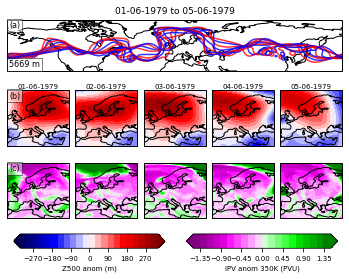

In [113]:
row_contents = ['Dates','Blocked']
csv_file = 'C:/Users/carlt/Documents/PhD/Plots/GTD/to_classify_1979-2019_boundary_sampday.csv'
append_list_as_row(csv_file, row_contents)  

#specify day_idx vals for days 0 - (92-num_days) in each period, so that overlaps are not considered
day_idx_vals = np.arange(zg_anom_dtrnd['time'].shape[0])

#147

with PdfPages(f'C:/Users/carlt/Documents/PhD/Plots/GTD/500z_IPV_GTD_classify_{num_days}_sampday.pdf') as pdf:
    for i, day_idx in enumerate(day_idx_vals):
        if i < 1:
            #test if running this day would create an overlap of different timesteps
            skip=False
            
            dates_str, fig = consecutive_weather_maps(day_idx, num_days)
            #append_list_as_row(csv_file, [dates_str, "0"])              
            pdf.savefig(fig, bbox_inches="tight")
            #plt.close(fig)
            
            #month, day = (int(zg_anom_dtrnd['time.month'][day_idx])), (int(zg_anom_dtrnd['time.day'][day_idx]))
            #day_month=(f"{month}{day}")
            #if int(day_month) in [528, 529, 530, 531, 827, 828, 829, 830, 831]: #include boundary cases
            #    print(day_month)
            #    dates_str, fig = consecutive_weather_maps(day_idx, num_days)
            #    append_list_as_row(csv_file, [dates_str, "0"])  
                #pdf.savefig(fig, bbox_inches="tight")
                #plt.close(fig)                
            #if day_idx != 0:
            #    for day in range(1, num_days):
            #        if day_idx%(92-day) == 0:
            #            skip=True
            #            print(f"skip {day_idx}")
            #            break
            #if not skip:
            #    dates_str, fig = consecutive_weather_maps(day_idx, num_days)
            #    append_list_as_row(csv_file, [dates_str, "0"])  
            #    pdf.savefig(fig, bbox_inches="tight")
            #    plt.close(fig)
                
                

In [78]:

def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)
        
        
      

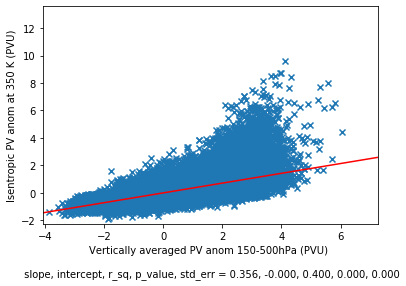

In [299]:

fig = plt.figure()

x, y = vpv_anom.values.flatten(), ipv_anom_350.values.flatten()

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.scatter(x[::100], y[::100], marker="x")

plot_line = np.array([float(x.min()), float(x.max())])
plt.xlim(float(x.min()), float(x.max()))
plt.ylim(float(y.min()), float(y.max()))
r_sq = r_value**2
plt.plot(plot_line, slope*plot_line+intercept, "r-", label = "fitted line")
plt.xlabel(f"Vertically averaged PV anom 150-500hPa (PVU) \n \n slope, intercept, r_sq, p_value, std_err = {slope:.3f}, {intercept:.3f}, {r_sq:.3f}, {p_value:.3f}, {std_err:.3f}")         
plt.ylabel("Isentropic PV anom at 350 K (PVU)")         
fig.savefig("C:/Users/carlt/Documents/PhD/Plots/VPV/VPV_vs_IPV.png", dpi = 300)

Convert the csv file back into the GTD file

In [42]:
styr, endyr = 1979, 2019
#select the time periods for each model from the start and end years
dayofyr_xr=[zg_file.sel(time=(slice(f"{yr}-05-26", f"{yr}-09-06")))['time'] for yr in range(int(styr),int(endyr)+1)]    
#select DJF to test TM90 index behaviour
#dayofyr_xr=[zg_file.sel(time=np.isin(zg_file['time.season'], "DJF"))]       

#concatenate the lists of boolean DataArray objects - also takes a few seconds
dayofyr_xr_concat = xarray.concat(dayofyr_xr, "time")

zg_file_sel = zg_file.sel(time = dayofyr_xr_concat['time']).squeeze()


<xarray.DataArray 'time' (time: 4264)>
array(['1979-05-26T10:30:00.000000000', '1979-05-27T10:30:00.000000000',
       '1979-05-28T10:30:00.000000000', ..., '2019-09-04T10:30:00.000000000',
       '2019-09-05T10:30:00.000000000', '2019-09-06T10:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-05-26T10:30:00 ... 2019-09-06T10:30:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [49]:
import csv
csv_file = 'C:/Users/carlt/Documents/PhD/Plots/GTD/to_classify_samp.csv'
csv_file = 'C:/Users/carlt/Documents/PhD/Plots/GTD/to_classify_1979-2019_boundary.csv'
csv_file = 'C:/Users/carlt/Documents/PhD/Plots/GTD/to_classify_tot.csv'
GTD_vals = np.zeros((zg_file_sel['time'].shape[0]))

with open(csv_file, mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for i, row in enumerate(csv_reader):
        #if i >3900:
            if line_count == 0:
                line_count += 1
            #print(row["Blocked"])
            if int(row["Blocked"]) == 1:
                #set days within period to be blocked
                st_date = str(row["ï»¿Dates"])[:10]
                st_day, st_mnth, st_yr = st_date[:2], st_date[3:5], st_date[-4:]
                end_date = str(row["ï»¿Dates"])[-10:]
                #print(f"{st_date} {end_date}")
                #identify the index of start date from the time file
                st_date_idx = np.where((zg_file_sel['time.day']==int(st_day)).values*(zg_file_sel['time.month']==int(st_mnth)).values*(zg_file_sel['time.year']==int(st_yr)).values)[0][0]
                GTD_vals[st_date_idx:st_date_idx+num_days]=1
            line_count += 1
            

In [51]:
sum(GTD_vals)/len(GTD_vals)

0.3102720450281426

In [52]:
GTD_xr = xr.DataArray(GTD_vals, name = "blocking", dims={"time": zg_file_sel['time']})
GTD_xr['time']=zg_file_sel['time']

GTD_xr.to_netcdf("C:/Users/carlt/Documents/PhD/Data/GTD/class_1979-2019_JJAextd.nc")

In [55]:
GTD_xr

<xarray.DataArray 'blocking' (time: 4264)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-26T10:30:00 ... 2019-09-06T10:30:00

In [56]:
GTD_xr.to_netcdf("C:/Users/carlt/Documents/PhD/Data/GTD/class_1979-2019_JJAextd.nc")